## HMM-GLM Model In Our Dataset

In [1]:
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation
import Preprocessing as pp
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score

npr.seed(0)

In [2]:
X, y = pp.extract_features(
    '../../behavior data integrated/Bhv 7 - Ctrl/M2/Contingency Flip/FED000_071823_00.CSV',
    True, False
    )

   Active_Poke  prev_event  bias
1            1           0     1
3            1           1     1
4            1           0     1
6            1           1     1
8            1           1     1


In [3]:
X

array([[1, 0, 1],
       [1, 1, 1],
       [1, 0, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

### Define and Train the HMM for 3 State

In [6]:
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 3         # input dimensions
max_iter = 500        # max number of iteration in EM part

# Make a GLM-HMM
three_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

In [10]:
log3 = three_glmhmm.fit(y, inputs=X, method='em', num_iters=max_iter, tolerance=10**-4)

  0%|          | 0/500 [00:00<?, ?it/s]

### Check Model Correct Rate

In [11]:
para = three_glmhmm.observations.params
tran = three_glmhmm.transitions.params

Text(0.5, 1.0, 'Generative transition matrix')

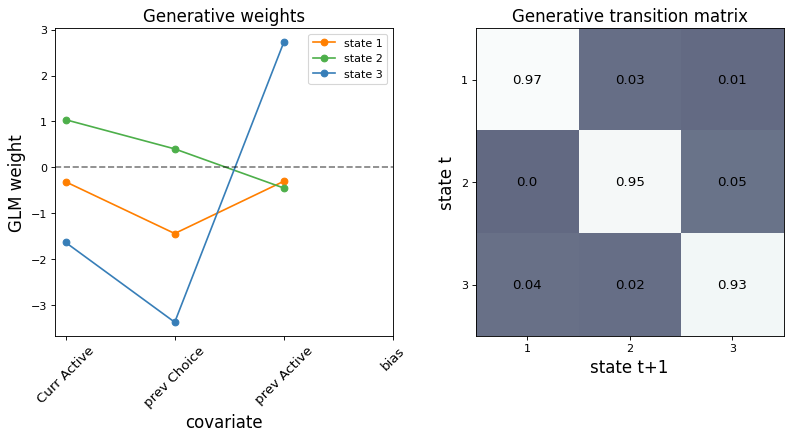

In [12]:
# Plot parameters:
fig = plt.figure(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#ff7f00', '#4daf4a', '#377eb8']
for k in range(num_states):
    plt.plot(range(input_dim), para[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1, 2, 3], ['Curr Active', 'prev Choice', 'prev Active', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(tran)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

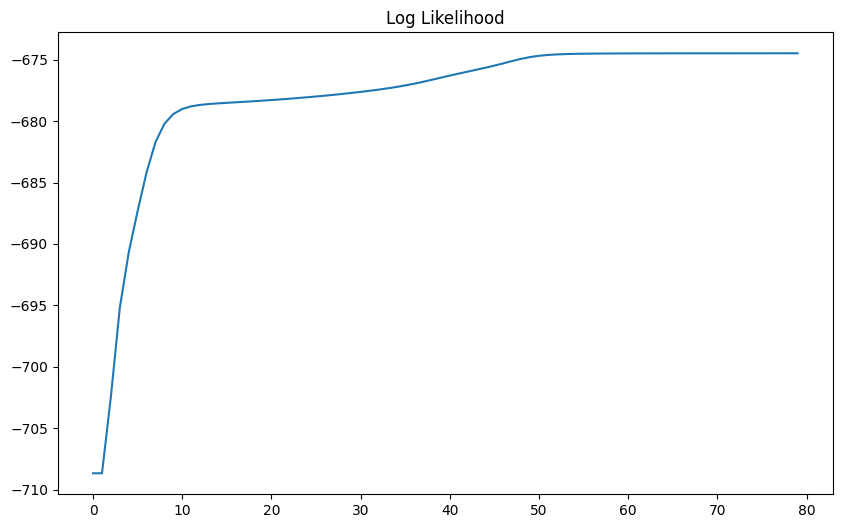

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(log3)
plt.title("Log Likelihood")
plt.show()

In [14]:
pred_state, pred_choice = three_glmhmm.sample(len(X), input=X)

/var/folders/kk/3lqkkjzx7kb59yj16vgzwnyh0000gn/T/ipykernel_5805/1347973638.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['State 1', 'State 2', 'State 3'], y=states_percent, width=0.6, palette='bright')


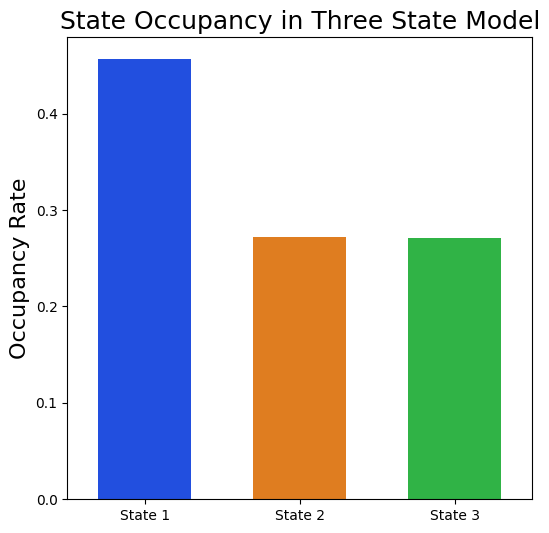

In [15]:
states = [0,0,0]
for state in pred_state:
    states[state] += 1
states_percent = [i/len(X) for i in states]

plt.figure(figsize=(6, 6))
sns.barplot(x=['State 1', 'State 2', 'State 3'], y=states_percent, width=0.6, palette='bright')
plt.title('State Occupancy in Three State Model', fontsize=18)
plt.ylabel('Occupancy Rate', fontsize=16)
plt.show()

In [16]:
accuracy = accuracy_score(y, pred_choice)
accuracy

0.5943661971830986

### accuracy in state

In [17]:
corr_state_acc = [0, 0, 0]

for idx, row in enumerate(X):
    # row[0] is active poke
    if row[0] == pred_choice[idx]:
        corr_state_acc[pred_state[idx]] += 1

for i in range(3):
    corr_state_acc[i] /= states[i]

corr_state_acc

[0.5041152263374485, 0.43448275862068964, 0.6262975778546713]